This script generates the fig 2d in the paper

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set(font_scale = 1.7)
sns.set_style('white')

### Read and reformat $R^2$ results

In [2]:
table_hlca = pd.read_csv("results/eval/performances_HLCA_loo_polyEN.csv")
table_cd = pd.read_csv("results/eval/performance_CD_polyEN.csv",index_col = 0).reset_index(drop = True)
table_nuc = pd.read_csv("results/eval/performances_nucseq_loo_polyEN.csv")

In [3]:
table_nuc["group"] = table_nuc["Group"]
table_nuc["cell_type"] = table_nuc["Cell type(Nuc-seq)"]

In [4]:
smoker_hlca = table_hlca.loc[table_hlca["group"] == "smoker",].copy()
nonsmoker_hlca = table_hlca.loc[table_hlca["group"] == "nonsmoker",].copy()
smoker_cd = table_cd.loc[table_cd["group"] == "smoker",].copy()
nonsmoker_cd = table_cd.loc[table_cd["group"] == "nonsmoker",].copy()
smoker_nuc = table_nuc.loc[table_nuc["group"] == "smoker",].copy()
nonsmoker_nuc = table_nuc.loc[table_nuc["group"] == "nonsmoker",].copy()

In [5]:
def reformat(table):
    table.replace("all_smoker",value = "All",inplace=True)
    table.replace("all_nonsmoker",value = "All",inplace=True)
    table.replace("all",value = "All",inplace=True)
    table.replace("union",value = "Union",inplace=True)
    table.replace("fridman",value = "Fridman",inplace=True)
    table.replace("sasp2",value = "SASP2",inplace=True)
    table.replace("senmayo",value = "SenMayo",inplace=True)
    table.replace("cellage",value = "CellAge",inplace=True)

    dfs = []
    n_rep = 5

    for i,(ct,df) in enumerate(table.groupby("cell_type")): # Iterate over each cell type
        ct_df = []
        for gene_type,dff in df.groupby("gene_type"): # Iterate over gene_type within each cell type
            gt_r2s = []
            gt_df = []
            for use_pca,dfff in dff.groupby("use_pca"):
                if dfff.iloc[0,:]["pred_age"] is not np.nan: # Get R2_mean for each use_pca
                    dfff["R2_mean"] = dfff["R2"].mean()
                    gt_r2s.append(dfff["R2"].mean())
                    gt_df.append(dfff)
            
            if len(gt_df) != 0:
                gt_df = pd.concat(gt_df)
                gt_df["R2_gene_type_best"] = max(gt_r2s)
                ct_df.append(gt_df)
            
        if len(ct_df) != 0: # If no gene_type and use_pca contains valid predictions, the current cell type will be skipped.
            ct_df = pd.concat(ct_df)
            ranking = ct_df.loc[:,["gene_type","R2_gene_type_best"]].drop_duplicates() # Assign ranking to each gene_type
            ranking = ranking.iloc[np.argsort(ranking["R2_gene_type_best"])[::-1],]
            ct_df["gene_type_ranking"] = 0
            for i,gt in enumerate(ranking["gene_type"]):
                ct_df.loc[ct_df["gene_type"] == gt,"gene_type_ranking"] = i+1
            
            ct_df.sort_values(by = "R2_mean",ascending = False,inplace=True)
            ct_df["R2_best"] = ct_df.iloc[0:n_rep,]["R2_mean"].mean() # The best mean R2 for the current cell type, from the best gene_type + use_pca combination
            ct_df["ind"] = str(i)
            dfs.append(ct_df)            
            
    table = pd.concat(dfs)
    
    del(table["R2"],
        table["rep"],
        table["pred_age"],
        table["true_age"]
       )
    
    if "MAE" in table.columns:
        del(table["MAE"])
        
    table.drop_duplicates(inplace=True)
    table.sort_values(by = "R2_best", ascending = False, inplace = True)
    
    return(table)

In [6]:
def keep_top_cts(table, n_top_ct = 20):
    ct_r2 = []
    for cell_type,df in table.groupby("cell_type"):
        best_r2 = df["R2_best"].mean()
        ct_r2.append([cell_type, best_r2])
    ct_r2.sort(key = lambda x:x[1], reverse = True)
    top_cts = [cell_type for cell_type,r2 in ct_r2[:n_top_ct]]
    
    return table.loc[table["cell_type"].isin(top_cts),].copy()

Not enough smokers available for nulear-seq data

In [7]:
smoker_hlca_plt = reformat(smoker_hlca)
smoker_cd_plt = reformat(smoker_cd)
#smoker_nuc_plt = reformat(smoker_nuc)
nonsmoker_hlca_plt = reformat(nonsmoker_hlca)
nonsmoker_cd_plt = reformat(nonsmoker_cd)
nonsmoker_nuc_plt = reformat(nonsmoker_nuc)

smoker_hlca_plt = keep_top_cts(smoker_hlca_plt, n_top_ct = 10)
smoker_cd_plt = keep_top_cts(smoker_cd_plt, n_top_ct = 10)
#smoker_nuc_plt = keep_top_cts(smoker_nuc_plt, n_top_ct = 20)
nonsmoker_hlca_plt = keep_top_cts(nonsmoker_hlca_plt, n_top_ct = 10)
nonsmoker_cd_plt = keep_top_cts(nonsmoker_cd_plt, n_top_ct = 10)
nonsmoker_nuc_plt = keep_top_cts(nonsmoker_nuc_plt, n_top_ct = 10)

In [8]:
smoker_hlca_plt["group"] = "HLCA(LOO)"
smoker_cd_plt["group"] = "CD"

nonsmoker_hlca_plt["group"] = "HLCA(LOO)"
nonsmoker_cd_plt["group"] = "CD"
nonsmoker_nuc_plt["group"] = "Nuc-seq(LOO)"

In [9]:
smoker_hlca_plt = smoker_hlca_plt.loc[:,["group","cell_type","gene_type","gene_type_ranking"]].drop_duplicates()
smoker_cd_plt = smoker_cd_plt.loc[:,["group","cell_type","gene_type","gene_type_ranking"]].drop_duplicates()

nonsmoker_hlca_plt = nonsmoker_hlca_plt.loc[:,["group","cell_type","gene_type","gene_type_ranking"]].drop_duplicates()
nonsmoker_cd_plt = nonsmoker_cd_plt.loc[:,["group","cell_type","gene_type","gene_type_ranking"]].drop_duplicates()
nonsmoker_nuc_plt = nonsmoker_nuc_plt.loc[:,["group","cell_type","gene_type","gene_type_ranking"]].drop_duplicates()

In [13]:
smoker_plt = pd.concat([smoker_hlca_plt,smoker_cd_plt])
nonsmoker_plt = pd.concat([nonsmoker_hlca_plt,nonsmoker_cd_plt,nonsmoker_nuc_plt])

In [14]:
#smoker_plt.loc[smoker_plt["gene_type"] != "All","gene_type"] = "Senescence"
#nonsmoker_plt.loc[nonsmoker_plt["gene_type"] != "All","gene_type"] = "Senescence"

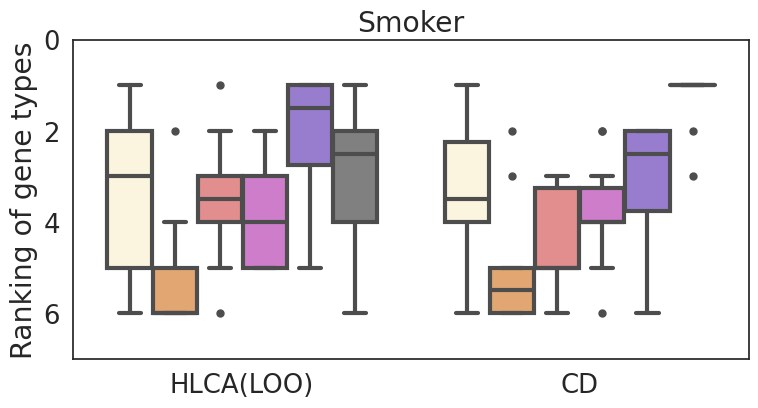

In [17]:
fig,ax = plt.subplots(nrows=1, ncols = 1, figsize = (8,4.5))
palette = {
          "CellAge":"cornsilk",
          "SASP2":"sandybrown",
          "Fridman":"lightcoral",
          "SenMayo":"orchid",
          "Union":"mediumpurple",
          "All":"grey"
          }
sns.boxplot(data = smoker_plt,
            x = "group",
            y="gene_type_ranking",
            hue = "gene_type",
            hue_order = ["CellAge","SASP2","Fridman","SenMayo","Union","All"],
            palette = palette,
            flierprops={"marker": "o"},
            linewidth = 3,
            ax = ax)
ax.set_ylim((7, 0))
#ax.set_yticks([-4,-3,-2,-1,0,0.25,0.5,0.75,1])
ax.set_ylabel("Ranking of gene types")
ax.set_xlabel("")
ax.get_legend().remove()
ax.set_title("Smoker")
plt.tight_layout()

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/sen_VS_allGenes_smoker_fig2d1.svg")

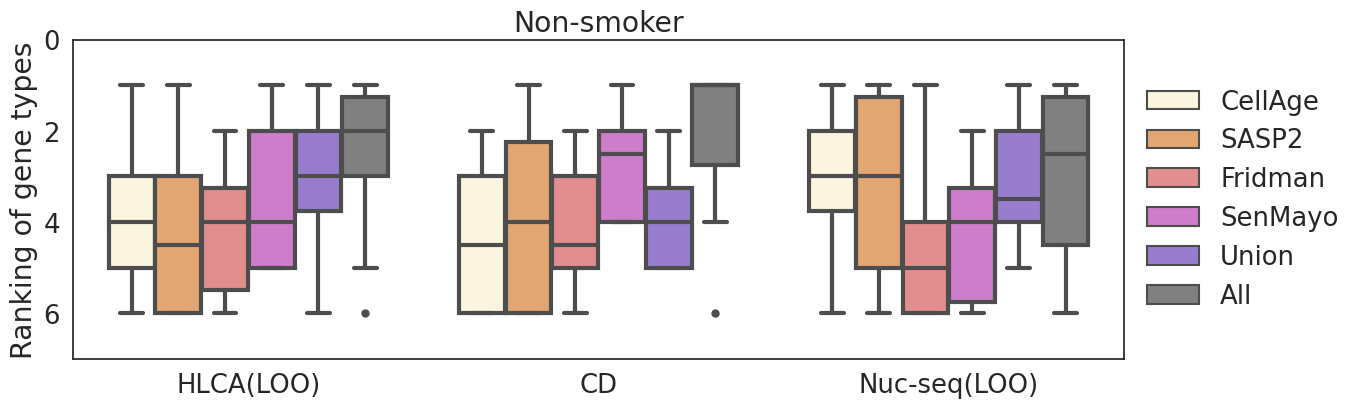

In [18]:
fig,ax = plt.subplots(nrows=1, ncols = 1, figsize = (14,4.5))
palette = {
          "CellAge":"cornsilk",
          "SASP2":"sandybrown",
          "Fridman":"lightcoral",
          "SenMayo":"orchid",
          "Union":"mediumpurple",
          "All":"grey"
          }
sns.boxplot(data = nonsmoker_plt,
            x = "group",
            y="gene_type_ranking",
            hue = "gene_type",
            hue_order = ["CellAge","SASP2","Fridman","SenMayo","Union","All"],
            palette = palette,
            flierprops={"marker": "o"},
            linewidth = 3,
            ax = ax)
ax.set_ylim((7, 0))
#ax.set_yticks([-4,-3,-2,-1,0,0.25,0.5,0.75,1])
ax.set_ylabel("Ranking of gene types")
ax.set_xlabel("")
ax.get_legend().remove()
ax.set_title("Non-smoker")
ax.legend(loc = "center left", frameon = False, bbox_to_anchor = (1,0.5))
plt.tight_layout()

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/sen_VS_allGenes_nonsmoker_fig2d2.svg")